In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# path of dataset file
import os
dataset = "/content/drive/My Drive/Colon Dataset/kvasir-seg/Kvasir-SEG/images/"
print(os.listdir(dataset))


['adenomatous', 'hyperplastic']


In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np



import random
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from pathlib import Path




In [ ]:
# Load pretrained AlexNet
alexnet = models.alexnet(pretrained=True)
alexnet.classifier = torch.nn.Sequential(*list(alexnet.classifier.children())[:-1])
alexnet.eval()

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def extract_features(image_path, model):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    with torch.no_grad():
        features = model(image)
    return features.squeeze().numpy()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 91.0MB/s]


In [ ]:
classes = os.listdir(dataset)
# Extract features and labels
features_list = []
labels_list = []

for label, class_dir in enumerate(classes):
    class_path = os.path.join(dataset, class_dir)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        features = extract_features(image_path, alexnet)
        features_list.append(features)
        labels_list.append(label)


features = np.vstack(features_list)
labels = np.hstack(labels_list)

print(f'Features shape: {features.shape}')

Features shape: (1000, 4096)


In [ ]:
print(f'Labels shape: {labels.shape}')

Labels shape: (1000,)


In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(features, labels_list, test_size=0.3, random_state=42)


SVM Accuracy: 0.7967
SVM Precision: 0.8061
SVM Recall: 0.8210
SVM F1 Score: 0.8135
SVM AUC: 0.8947


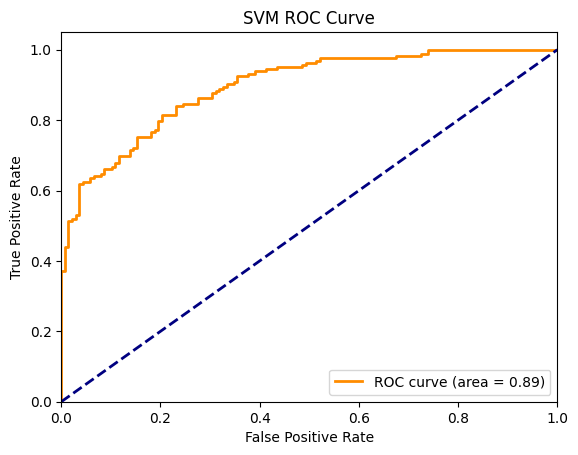

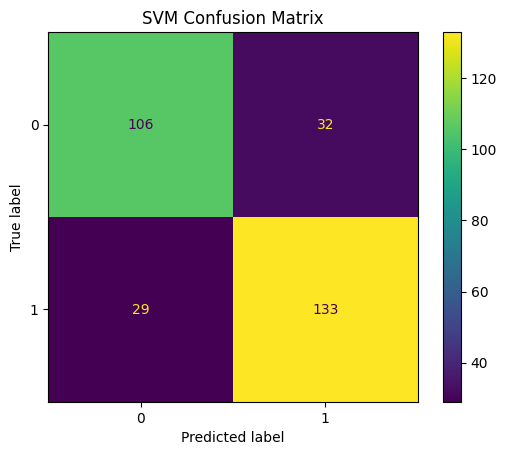

In [ ]:

# Assuming X_train, X_test, y_train, y_test are already defined

# Function to plot ROC curve
def plot_roc_curve(fpr, tpr, roc_auc, title):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Train and evaluate SVM
svm = SVC(kernel='poly', probability=True)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
y_score_svm = svm.decision_function(X_test)

# Compute metrics for SVM
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_score_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

print(f'SVM Accuracy: {accuracy_svm:.4f}')
print(f'SVM Precision: {precision_svm:.4f}')
print(f'SVM Recall: {recall_svm:.4f}')
print(f'SVM F1 Score: {f1_svm:.4f}')
print(f'SVM AUC: {roc_auc_svm:.4f}')

# Plot ROC curve for SVM
plot_roc_curve(fpr_svm, tpr_svm, roc_auc_svm, 'SVM ROC Curve')

# Confusion matrix for SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm)
disp_svm.plot()
plt.title('SVM Confusion Matrix')
plt.show()

